# 人脸识别模型训练与评估（含多指标量化评估）

In [54]:
import os
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_curve, auc, f1_score,
    precision_score, recall_score, cohen_kappa_score
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## 数据路径设置

In [55]:
# 数据路径
train_dir = "split_data/train"
test_dir = "split_data/test"
test_out_dir = "split_data/test_out"

## 图像预处理函数（含数据增强）

In [56]:
# 图像预处理函数，数据增强
def preprocess_image(image_path, target_size=(64, 64), is_train=False):
    img = Image.open(image_path).convert("L")  # 转为灰度图
    width, height = img.size
    
    if is_train:
        # 1. 随机裁剪与缩放（模拟不同人脸位置）
        scale = np.random.uniform(0.8, 1.2)  # 缩放比例
        new_size = (int(target_size[0] * scale), int(target_size[1] * scale))
        img = img.resize(new_size)
        
        # 2. 随机裁剪回目标尺寸
        x = np.random.randint(0, new_size[0] - target_size[0] + 1)
        y = np.random.randint(0, new_size[1] - target_size[1] + 1)
        img = img.crop((x, y, x + target_size[0], y + target_size[1]))
        
        # 3. 数据增强（原有基础上新增高斯噪声）
        if np.random.random() > 0.5:
            img = img.rotate(np.random.randint(-15, 15))  # 扩大旋转范围
        if np.random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(np.random.uniform(0.7, 1.3))  # 扩大亮度调整范围
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(np.random.uniform(0.8, 1.2))  # 新增对比度调整
        if np.random.random() > 0.3:  # 新增高斯噪声
            img = img.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0, 1)))
    
    else:
        # 测试集仅中心裁剪和归一化
        x = (width - target_size[0]) // 2
        y = (height - target_size[1]) // 2
        img = img.crop((x, y, x + target_size[0], y + target_size[1]))
    
    # 直方图均衡化和归一化
    img = ImageOps.equalize(img)
    img = np.array(img) / 255.0
    return img.flatten()  # 展平为一维向量

## 加载数据集函数

In [57]:
# 加载数据集
# 加载数据集，同时返回文件名列表
def load_dataset(data_dir, target_size=(64, 64), max_images_per_person=None):
    # print(f"开始加载 {data_dir} 数据集...")
    data = []
    labels = []
    filenames = []  # 用于存储文件名
    for subject_id in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_id)
        if os.path.isdir(subject_path):
            images = os.listdir(subject_path)
            if max_images_per_person:
                images = images[:max_images_per_person]
            for img_name in images:
                img_path = os.path.join(subject_path, img_name)
                img = preprocess_image(img_path, target_size)
                data.append(img)
                labels.append(subject_id)
                filenames.append(f"{subject_id}/{img_name}")  # 保存文件名，包含子文件夹路径
    print(f"{data_dir} 数据集加载完成。")
    return np.array(data), np.array(labels), filenames

## PCA 降维函数

In [58]:
# PCA 降维函数
def pca_reduction(train_data, test_data, test_out_data, n_components):
    print(f"开始进行 PCA 降维，保留 {n_components} 个主成分...")
    train_data_flat = train_data.reshape(train_data.shape[0], -1)
    test_data_flat = test_data.reshape(test_data.shape[0], -1)
    test_out_data_flat = test_out_data.reshape(test_out_data.shape[0], -1)

    mean_face = np.mean(train_data_flat, axis=0)

    train_data_centered = train_data_flat - mean_face
    test_data_centered = test_data_flat - mean_face
    test_out_data_centered = test_out_data_flat - mean_face

    # 动态调整 n_components
    max_components = min(train_data_centered.shape[0], train_data_centered.shape[1])
    if n_components > max_components:
        print(f"警告: n_components={n_components} 超出范围，调整为 {max_components}")
        n_components = max_components

    pca = PCA(n_components=n_components)
    train_data_pca = pca.fit_transform(train_data_centered)
    test_data_pca = pca.transform(test_data_centered)
    test_out_data_pca = pca.transform(test_out_data_centered)
    print("PCA 降维完成。")
    return train_data_pca, test_data_pca, test_out_data_pca

## 为每个人训练一个 SVM 分类器

In [59]:
from sklearn.model_selection import StratifiedKFold

def train_svm_classifiers(train_data, train_labels):
    print("开始训练 SVM 分类器...")
    unique_labels = np.unique(train_labels)
    classifiers = {}
    # for label in unique_labels:
    #     binary_labels = (train_labels == label).astype(int)
    #     param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01], 'kernel': ['rbf']}
    #     # 使用分层采样
    #     cv = StratifiedKFold(n_splits=3)
    #     grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv)
    #     grid_search.fit(train_data, binary_labels)
    #     best_svm = grid_search.best_estimator_
    #     classifiers[label] = best_svm
    for label in unique_labels:
        binary_labels = (train_labels == label).astype(int)
        # 直接使用固定参数，无需网格搜索
        svm = SVC(probability=True, C=0.01, gamma=0.001, kernel='rbf')
        svm.fit(train_data, binary_labels)
        classifiers[label] = svm
    print("SVM 分类器训练完成。")
    return classifiers

## 投票预测函数

In [60]:
# 投票预测
def vote_predict(classifiers, data, threshold):
    # print("开始进行投票预测...")
    predictions = []
    all_scores = []
    for sample in data:
        scores = []
        for label, classifier in classifiers.items():
            score = classifier.predict_proba([sample])[0][1]
            scores.append(score)
        max_score = np.max(scores)
        all_scores.append(max_score)
        if max_score < threshold:
            predictions.append("OUT")
        else:
            predictions.append("IN")
    # print("投票预测完成。")
    return np.array(predictions), np.array(all_scores)

## 预测具体人员函数

In [61]:
# 预测具体人员
def predict_person(classifiers, data):
    predictions = []
    for sample in data:
        scores = []
        labels = []
        for label, classifier in classifiers.items():
            score = classifier.predict_proba([sample])[0][1]
            scores.append(score)
            labels.append(label)
        predicted_label = labels[np.argmax(scores)]
        predictions.append(predicted_label)
    return np.array(predictions)

## 主成分分析验证

split_data/train 数据集加载完成。
绘制平均脸和前10个特征脸...


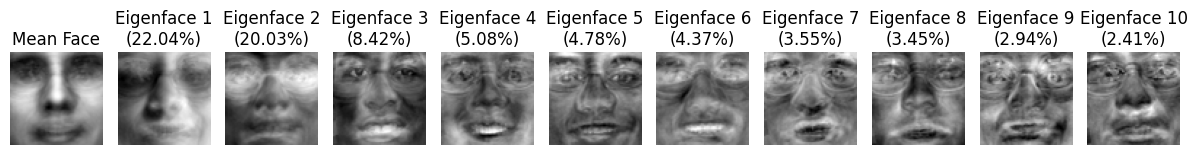

绘制完成。
将 PCA 结果保存到 Excel 文件...
PCA 结果已保存到 pca_results.xlsx。


In [62]:
# 画出平均脸和前10个特征脸
def plot_mean_and_top_eigenfaces(train_data, n_components=50, top_n=10):
    print("绘制平均脸和前10个特征脸...")
    train_data_flat = train_data.reshape(train_data.shape[0], -1)
    mean_face = np.mean(train_data_flat, axis=0)
    
    # PCA 降维
    pca = PCA(n_components=n_components)
    pca.fit(train_data_flat - mean_face)
    eigenfaces = pca.components_.reshape((n_components, 64, 64))
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 绘制平均脸
    plt.figure(figsize=(12, 6))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(mean_face.reshape(64, 64), cmap='gray')
    plt.title("Mean Face")
    plt.axis("off")
    
    # 绘制前10个特征脸
    for i in range(top_n):
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(eigenfaces[i], cmap='gray')
        plt.title(f"Eigenface {i + 1}\n({explained_variance_ratio[i]:.2%})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    print("绘制完成。")

# 将所有训练图像的主成分分析后的结果输出为 Excel（主成分=50）
import pandas as pd


def save_pca_to_excel_with_filenames(train_data, filenames, n_components=50, output_file="pca_results.xlsx"):
    print("将 PCA 结果保存到 Excel 文件...")
    train_data_flat = train_data.reshape(train_data.shape[0], -1)
    mean_face = np.mean(train_data_flat, axis=0)
    
    # PCA 降维
    pca = PCA(n_components=n_components)
    train_data_pca = pca.fit_transform(train_data_flat - mean_face)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 保存主成分结果
    df_pca = pd.DataFrame(train_data_pca, columns=[f"PC{i + 1}" for i in range(n_components)])
    df_pca.insert(0, "Filename", filenames)  # 将文件名插入为第一列
    df_pca.to_excel(output_file, index=False, sheet_name="PCA Results")
    
    # 保存方差贡献率
    df_variance = pd.DataFrame({
        "Principal Component": [f"PC{i + 1}" for i in range(n_components)],
        "Explained Variance (%)": explained_variance_ratio * 100
    })
    with pd.ExcelWriter(output_file, mode="a", engine="openpyxl") as writer:
        df_variance.to_excel(writer, index=False, sheet_name="Explained Variance")
    
    print(f"PCA 结果已保存到 {output_file}。")
# 加载数据集
n = 6  # 每个人读取的图片数量
train_data, train_labels, filenames = load_dataset(train_dir, max_images_per_person=n)

# 绘制平均脸和前10个特征脸
plot_mean_and_top_eigenfaces(train_data, n_components=40, top_n=10)

# 保存 PCA 结果到 Excel
save_pca_to_excel_with_filenames(train_data, filenames, n_components=40, output_file="pca_results.xlsx")


## 模型评估主流程

split_data/train 数据集加载完成。
split_data/test 数据集加载完成。
split_data/test_out 数据集加载完成。
数据加载完成！
训练集大小: (60, 4096), 测试集大小: (30, 4096), 数据集外测试集大小: (30, 4096)
开始进行 PCA 降维，保留 50 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
最优阈值: 0.740

==== 系统内外判断指标 ====
准确率: 0.85
精确率: 0.92
召回率: 0.77
特异性: 0.93
F1分数: 0.84
Kappa系数: 0.70
AUC值: 0.85


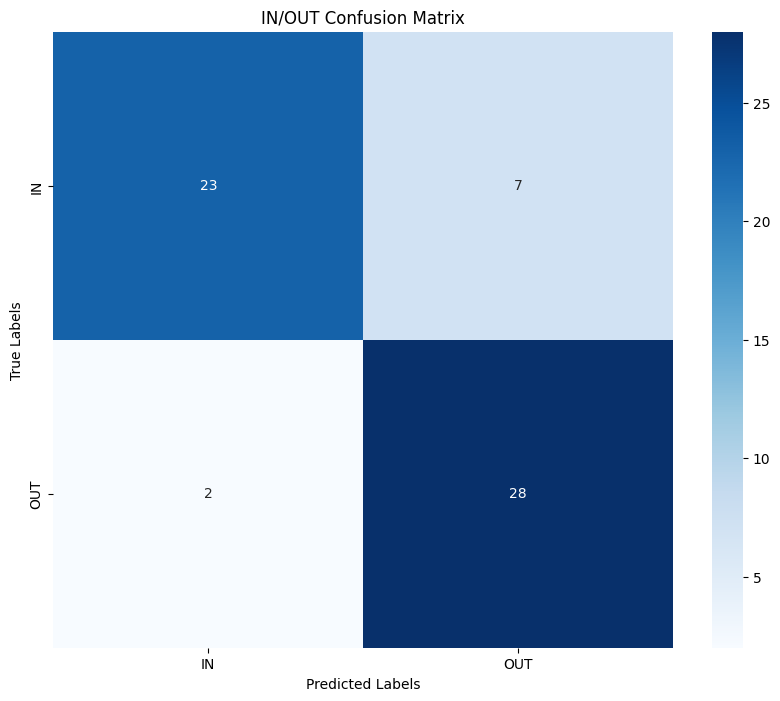

In [85]:
# 加载数据集
n = 6  # 每个人读取的图片数量
train_data, train_labels, filenames = load_dataset(train_dir, max_images_per_person=n)
test_data, test_labels, filenames = load_dataset(test_dir, max_images_per_person=n)
test_out_data, test_out_labels, filenames = load_dataset(test_out_dir, max_images_per_person=n)

print("数据加载完成！")
print(f"训练集大小: {train_data.shape}, 测试集大小: {test_data.shape}, 数据集外测试集大小: {test_out_data.shape}")

# PCA 降维
n_components = 50
train_data_pca, test_data_pca, test_out_data_pca = pca_reduction(train_data, test_data, test_out_data, n_components)

# 训练分类器
classifiers = train_svm_classifiers(train_data_pca, train_labels)

# 计算最优阈值
# print("开始计算最优阈值...")
all_predictions, all_scores = vote_predict(classifiers, np.concatenate([test_data_pca, test_out_data_pca]), 0.5)
true_labels = np.concatenate([np.ones(len(test_labels)), np.zeros(len(test_out_labels))])
fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
roc_auc = auc(fpr, tpr)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"最优阈值: {optimal_threshold:.3f}")

# 使用最优阈值进行预测
test_predictions, _ = vote_predict(classifiers, test_data_pca, optimal_threshold)
test_out_predictions, _ = vote_predict(classifiers, test_out_data_pca, optimal_threshold)
all_predictions = np.concatenate([test_predictions, test_out_predictions])
all_true_labels = np.concatenate([["IN"] * len(test_labels), ["OUT"] * len(test_out_labels)])

# ====================== 系统内外判断评估 ======================
# 生成混淆矩阵
cm = confusion_matrix(all_true_labels, all_predictions, labels=["IN", "OUT"])
tp, fp, fn, tn = cm[0,0], cm[1,0], cm[0,1], cm[1,1]

# 新增评估指标
in_out_accuracy = accuracy_score(all_true_labels, all_predictions)
in_out_precision = precision_score(all_true_labels, all_predictions, pos_label="IN")
in_out_recall = recall_score(all_true_labels, all_predictions, pos_label="IN")
in_out_f1 = f1_score(all_true_labels, all_predictions, pos_label="IN") 
in_out_specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
in_out_kappa = cohen_kappa_score(all_true_labels, all_predictions)

# 输出所有指标
print("\n==== 系统内外判断指标 ====")
print(f"准确率: {in_out_accuracy:.2f}")
print(f"精确率: {in_out_precision:.2f}")
print(f"召回率: {in_out_recall:.2f}")
print(f"特异性: {in_out_specificity:.2f}")
print(f"F1分数: {in_out_f1:.2f}")
print(f"Kappa系数: {in_out_kappa:.2f}")
print(f"AUC值: {roc_auc:.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["IN", "OUT"], yticklabels=["IN", "OUT"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('IN/OUT Confusion Matrix')
plt.show()

## 人员识别评估


==== 人员识别指标 ====
准确率: 0.83
加权F1分数: 0.84
宏平均F1分数: 0.84
宏平均精确率: 0.89
宏平均召回率: 0.83
Kappa系数: 0.81


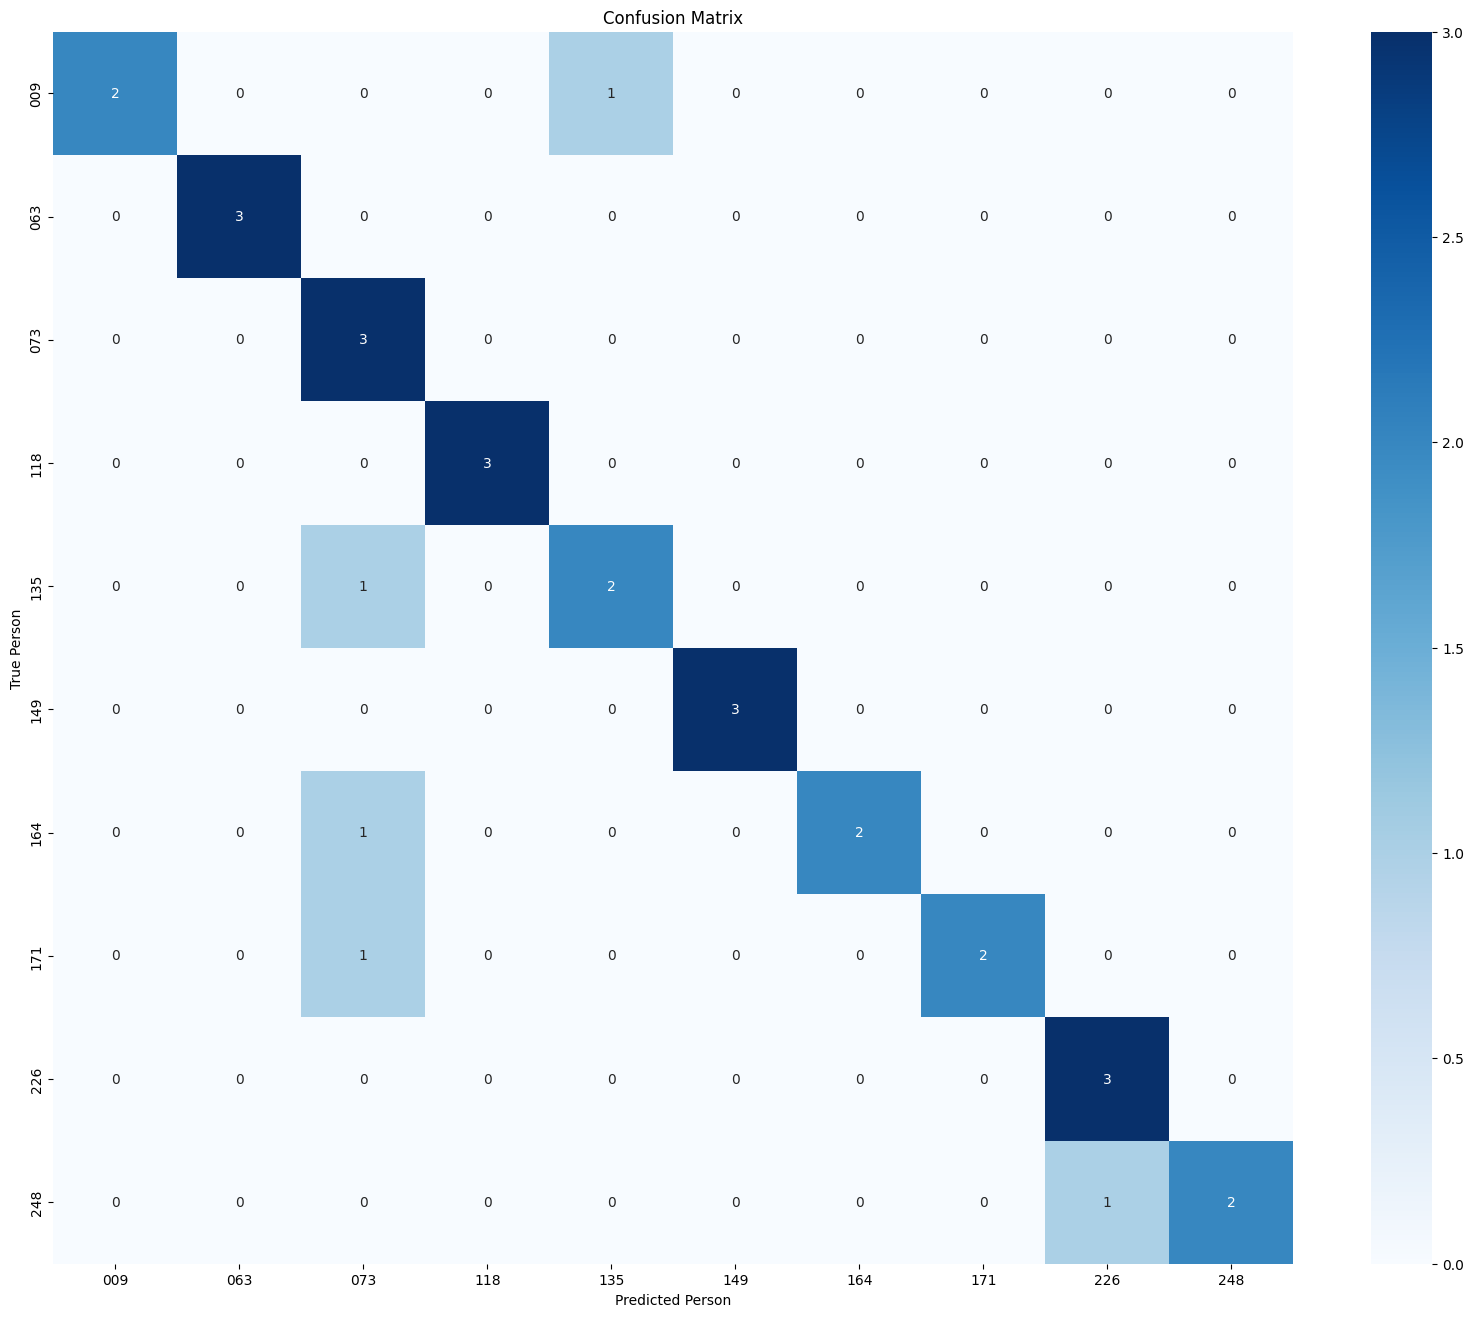

In [97]:
# 预测具体人员
person_predictions = predict_person(classifiers, test_data_pca)

# 生成混淆矩阵
person_cm = confusion_matrix(test_labels, person_predictions)
person_labels = sorted(np.unique(train_labels))

# 多分类评估指标
person_accuracy = accuracy_score(test_labels, person_predictions)
person_f1_weighted = f1_score(test_labels, person_predictions, average='weighted')
person_f1_macro = f1_score(test_labels, person_predictions, average='macro')
person_precision_macro = precision_score(test_labels, person_predictions, average='macro')
person_recall_macro = recall_score(test_labels, person_predictions, average='macro')
person_kappa = cohen_kappa_score(test_labels, person_predictions)

# 输出指标
print("\n==== 人员识别指标 ====")
print(f"准确率: {person_accuracy:.2f}")
print(f"加权F1分数: {person_f1_weighted:.2f}")
print(f"宏平均F1分数: {person_f1_macro:.2f}")
print(f"宏平均精确率: {person_precision_macro:.2f}")
print(f"宏平均召回率: {person_recall_macro:.2f}")
print(f"Kappa系数: {person_kappa:.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(20, 16))
sns.heatmap(person_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=person_labels, yticklabels=person_labels)
plt.xlabel('Predicted Person')
plt.ylabel('True Person')
plt.title('Confusion Matrix')
plt.show()

## 不同参数测试

split_data/test 数据集加载完成。
split_data/test_out 数据集加载完成。
开始测试不同图片个数 n 的效果（多次测试取平均值）...
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告: n_components=50 超出范围，调整为 10
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
split_data/train 数据集加载完成。
开始进行 PCA 降维，保留 50 个主成分...
警告:

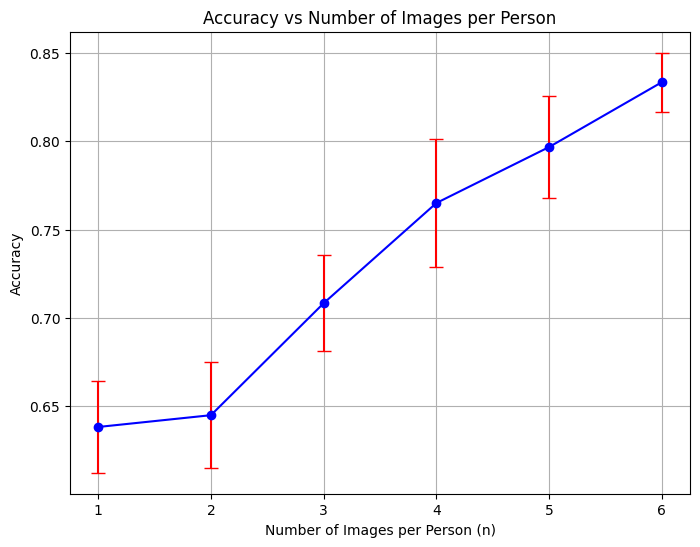

不同图片个数 n 的测试完成。
split_data/train 数据集加载完成。
开始测试不同主成分数 n_components 的效果（多次测试取平均值）...
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 10 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
n_components = 10, 平均准确率: 0.77, 标准差: 0.03
开始进行 PCA 降维，保留 20 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 20 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 20 个主成分...
PCA 降维完成。
开始训练 SVM 分类器...
SVM 分类器训练完成。
开始进行 PCA 降维，保留 20 个主成分...
PCA 

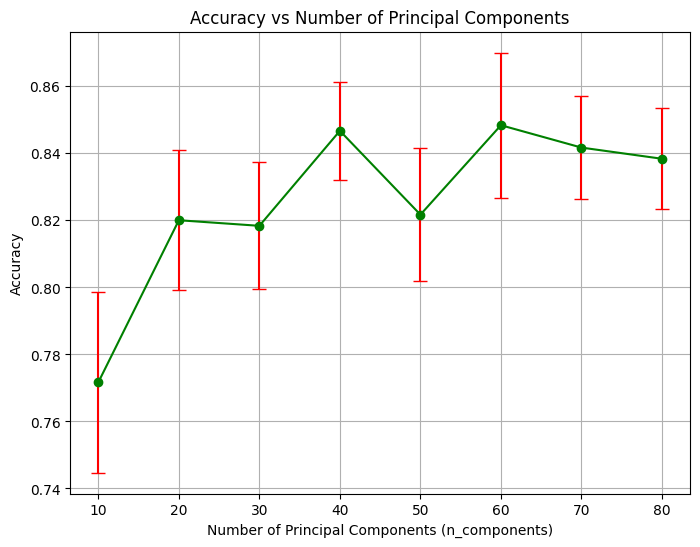

不同主成分数 n_components 的测试完成。


In [65]:
# 测试不同图片个数 n 的效果（多次测试取平均值）
def evaluate_different_n(train_dir, test_data, test_labels, test_out_data, test_out_labels, n_components, n_values, num_repeats=10):
    print("开始测试不同图片个数 n 的效果（多次测试取平均值）...")
    results = []
    for n in n_values:
        # print(f"\n当前 n = {n}")
        accuracies = []
        for repeat in range(num_repeats):
            # print(f"  第 {repeat + 1}/{num_repeats} 次实验...")
            # 加载训练集
            train_data, train_labels ,_= load_dataset(train_dir, max_images_per_person=n)
            train_data_pca, test_data_pca, test_out_data_pca = pca_reduction(train_data, test_data, test_out_data, n_components)
            
            # 训练分类器
            classifiers = train_svm_classifiers(train_data_pca, train_labels)
            
            # 使用最优阈值进行预测
            all_predictions, all_scores = vote_predict(classifiers, np.concatenate([test_data_pca, test_out_data_pca]), 0.5)
            true_labels = np.concatenate([np.ones(len(test_labels)), np.zeros(len(test_out_labels))])
            fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
            optimal_threshold = thresholds[np.argmax(tpr - fpr)]
            
            # 重新预测
            test_predictions, _ = vote_predict(classifiers, test_data_pca, optimal_threshold)
            test_out_predictions, _ = vote_predict(classifiers, test_out_data_pca, optimal_threshold)
            all_predictions = np.concatenate([test_predictions, test_out_predictions])
            all_true_labels = np.concatenate([["IN"] * len(test_labels), ["OUT"] * len(test_out_labels)])
            
            # 计算准确率
            in_out_accuracy = accuracy_score(all_true_labels, all_predictions)
            accuracies.append(in_out_accuracy)
        
        # 计算平均值和标准差
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        print(f"n = {n}, 平均准确率: {mean_accuracy:.2f}, 标准差: {std_accuracy:.2f}")
        results.append((n, mean_accuracy, std_accuracy))
    
    # 绘制结果
    n_values, mean_accuracies, std_accuracies = zip(*results)
    plt.figure(figsize=(8, 6))
    plt.errorbar(n_values, mean_accuracies, yerr=std_accuracies, fmt='o-', color='b', ecolor='r', capsize=5)
    plt.xlabel("Number of Images per Person (n)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of Images per Person")
    plt.grid()
    plt.show()
    print("不同图片个数 n 的测试完成。")


# 测试不同主成分数 n_components 的效果（多次测试取平均值）
def evaluate_different_components(train_data, train_labels, test_data, test_labels, test_out_data, test_out_labels, n_components_values, num_repeats=10):
    print("开始测试不同主成分数 n_components 的效果（多次测试取平均值）...")
    results = []
    for n_components in n_components_values:
        # print(f"\n当前 n_components = {n_components}")
        accuracies = []
        for repeat in range(num_repeats):
            # print(f"  第 {repeat + 1}/{num_repeats} 次实验...")
            train_data_pca, test_data_pca, test_out_data_pca = pca_reduction(train_data, test_data, test_out_data, n_components)
            
            # 训练分类器
            classifiers = train_svm_classifiers(train_data_pca, train_labels)
            
            # 使用最优阈值进行预测
            all_predictions, all_scores = vote_predict(classifiers, np.concatenate([test_data_pca, test_out_data_pca]), 0.5)
            true_labels = np.concatenate([np.ones(len(test_labels)), np.zeros(len(test_out_labels))])
            fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
            optimal_threshold = thresholds[np.argmax(tpr - fpr)]
            
            # 重新预测
            test_predictions, _ = vote_predict(classifiers, test_data_pca, optimal_threshold)
            test_out_predictions, _ = vote_predict(classifiers, test_out_data_pca, optimal_threshold)
            all_predictions = np.concatenate([test_predictions, test_out_predictions])
            all_true_labels = np.concatenate([["IN"] * len(test_labels), ["OUT"] * len(test_out_labels)])
            
            # 计算准确率
            in_out_accuracy = accuracy_score(all_true_labels, all_predictions)
            accuracies.append(in_out_accuracy)
        
        # 计算平均值和标准差
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        print(f"n_components = {n_components}, 平均准确率: {mean_accuracy:.2f}, 标准差: {std_accuracy:.2f}")
        results.append((n_components, mean_accuracy, std_accuracy))
    
    # 绘制结果
    n_components_values, mean_accuracies, std_accuracies = zip(*results)
    plt.figure(figsize=(8, 6))
    plt.errorbar(n_components_values, mean_accuracies, yerr=std_accuracies, fmt='o-', color='g', ecolor='r', capsize=5)
    plt.xlabel("Number of Principal Components (n_components)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of Principal Components")
    plt.grid()
    plt.show()
    print("不同主成分数 n_components 的测试完成。")

# 主程序：测试不同 n 和 n_components 的效果
if __name__ == "__main__":
    # 加载测试集和系统外测试集
    test_data, test_labels, _ = load_dataset(test_dir, max_images_per_person=n)
    test_out_data, test_out_labels , _ = load_dataset(test_out_dir, max_images_per_person=n)
    
    # 测试不同图片个数 n 的效果
    n_values = [1,2,3,4,5,6]  # 每人读取的图片数量
    evaluate_different_n(train_dir, test_data, test_labels, test_out_data, test_out_labels, n_components=50, n_values=n_values)
    
    # 加载训练集（固定 n = 6）
    train_data, train_labels, _ = load_dataset(train_dir, max_images_per_person=6)
    
    # 测试不同主成分数 n_components 的效果
    n_components_values = [10, 20, 30, 40, 50, 60, 70, 80]
    evaluate_different_components(train_data, train_labels, test_data, test_labels, test_out_data, test_out_labels, n_components_values)